In [0]:
import pandas as pd
import numpy as np
from scipy import stats
np.random.seed(1337)

import seaborn as sns
import plotly
import plotly.offline as py
plotly.offline.init_notebook_mode()
import plotly.graph_objs as go
%matplotlib inline
from plotly.graph_objs import *

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import minmax_scale

from functools import reduce
import scipy.fftpack
import matplotlib.pyplot as plt
import math

Output hidden; open in https://colab.research.google.com to view.

#Low-pass filter

In [0]:
from scipy.signal import butter, lfilter, freqz

cutoff = 6
order = 10
fs = 52.0       # sample rate, Hz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [0]:
## Preprocessing
def preprocess(dataset):
    """
    column names 
    """
    dataset.columns = ['time', 'x', 'y', 'z', 'label']
    return dataset

def rectify(bundle):
    """
    remove noise at the beginnng
    """
    dataset, step = bundle
    length = dataset.shape[0]
    tl = dataset[['time', 'label']][:length-step]
    xyz = dataset[['x', 'y', 'z']][step:].reset_index()[['x', 'y', 'z']]
    return pd.concat([tl, xyz], axis=1)[['time', 'x', 'y', 'z', 'label']]

def normalize(dataset):
    bottom = min(dataset['x'].mean(), dataset['y'].mean(),dataset['z'].mean())
    top = max(dataset['x'].mean(), dataset['y'].mean(),dataset['z'].mean())

    dataset['x'] = dataset['x'] / bottom
    dataset['y'] = dataset['y'] / bottom
    dataset['z'] = dataset['z'] / bottom
    return dataset

def low_pass(dataset):

    for ax in 'xyz':
        dataset[ax] = butter_lowpass_filter(dataset[ax], cutoff, fs, order)
    return dataset

In [0]:
def extract_rnn_info(data):
    xyz = data[['x','y','z']].apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return np.array(xyz)

In [0]:
def raw_info(data):
    """
    basic feature engineering
    """
    info = []
    for ax in 'xyz':
        d = data[ax]
        info.append(d.mean())
        info.append(d.min())
        info.append(d.max())
        for percent in [25, 50, 75]:
            info.append(np.percentile(d, percent))
        info.append(d.std())
        info.append(np.abs(np.diff(d)).mean())
        info.append(stats.sem(d))
        info.append(stats.skew(d))
        info.append(np.sqrt(np.mean(np.square(d))))
    return np.array(info)

In [0]:
def seq_cut_dataset(dataset):
    results = []
    
    last_label = 1
    last_index = 0
    index = 0
    for row in dataset.itertuples():
        if row[5] == last_label:
            index = index + 1
            continue
        if last_label == 0:
            index = index + 1
            continue  
        results.append((last_label, dataset.loc[last_index:index-1]))
        last_label = row[5]
        last_index = index
        index = index + 1
    return results

In [0]:
CLASS_NUM = 7
def extract_feature(dataset):

    SEQ_N = int(300)
    activity_label = []
    activity_feature = []

    class_map = [0,1,2,3,4,5,6]
    for aid, data in seq_cut_dataset(dataset):
        step = SEQ_N
        for start in range(0, len(data), step):
            end = len(data)
            if start + SEQ_N < len(data):
                end = start + SEQ_N
            else:
                start = len(data) - SEQ_N
                if len(data) <= (SEQ_N):
                    print('skip', end-start, len(data))
                    continue
            seq = data.iloc[start:end]
            class_id = class_map[aid - 1]
            
            features = extract_rnn_info(seq)
            activity_label.append(class_id)
            activity_feature.append(features)
    return np.array(activity_label), np.array(activity_feature)

In [0]:
def extract_feature2(dataset):

    SEQ_N = int(300)
    activity_label = []
    activity_feature = []

    class_map = [0,1,2,3,4,5,6]
    for aid, data in seq_cut_dataset(dataset):
        step = SEQ_N
        for start in range(0, len(data), step):
            end = len(data)
            if start + SEQ_N < len(data):
                end = start + SEQ_N
            else:
                start = len(data) - SEQ_N
                if len(data) <= (SEQ_N):
                    print('skip', end-start, len(data))
                    continue
            seq = data.iloc[start:end]
            class_id = class_map[aid - 1]
            
            features = raw_info(seq)
            activity_label.append(class_id)
            activity_feature.append(features)
    return np.array(activity_label), np.array(activity_feature)

In [0]:
def get_X_y(bundle):
    y = np.concatenate([b[0] for b in bundle], axis=0)
    X = np.concatenate([b[1] for b in bundle], axis=0)
    return X, y

In [0]:
## initial setup for google drive and colab
import glob
import importlib
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
import os
pathtodata = '/content/gdrive/My Drive/Activity Recognition from Single Chest-Mounted Accelerometer/'
os.chdir(pathtodata)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
rectify_steps = [0, 2650, 0, 2100, 0, 2400, 0, 3275, 1700, 0, 0, 0, 1100, 0, 5500]

datasets = [pd.read_csv(pathtodata + str(i) + '.csv', header=None, skipinitialspace=True) for i in range(1, 16)]
datasets = list(map(preprocess, datasets))
datasets = list(map(rectify, zip(datasets, rectify_steps)))
datasets = list(map(normalize, datasets))
datasets = list(map(low_pass, datasets))

trainsets = datasets[:12]
testsets = datasets[12:]

In [0]:
train_act_fea_list = list(map(extract_feature, trainsets))
test_act_fea_list = list(map(extract_feature, testsets))
all_act_fea_list = train_act_fea_list + test_act_fea_list

In [0]:
train_act_fea_list2 = list(map(extract_feature2, trainsets))
test_act_fea_list2 = list(map(extract_feature2, testsets))
all_act_fea_list2 = train_act_fea_list2 + test_act_fea_list2

In [0]:
train_X, train_y = get_X_y(train_act_fea_list)
test_X, test_y = get_X_y(test_act_fea_list)
all_X, all_y = get_X_y(all_act_fea_list)

In [0]:
train_X2, train_y2 = get_X_y(train_act_fea_list2)
test_X2, test_y2 = get_X_y(test_act_fea_list2)
all_X2, all_y2 = get_X_y(all_act_fea_list2)

In [0]:
print(train_X.shape)
print(train_X2.shape)

(4230, 300, 3)
(4230, 33)


In [0]:
from keras.models import Sequential, Model
from keras.layers import add
from keras.layers import Convolution1D, MaxPooling1D, Dense, Dropout, Activation, Flatten,concatenate
from keras.utils import np_utils
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasClassifier
import warnings
warnings.filterwarnings("ignore")
def build_model():
    model1 = Sequential()
    model1.add(Convolution1D(input_shape=train_X.shape[1:],
                            nb_filter=128,
                            filter_length=3,
                            border_mode='same',
                            activation='relu'))
    model1.add(MaxPooling1D(pool_length=2))
    model1.add(Convolution1D(nb_filter=128,
                            filter_length=3,
                            border_mode='same',
                            activation='relu'))
    model1.add(MaxPooling1D(pool_length=2))
    model1.add(Convolution1D(nb_filter=128,
                            filter_length=3,
                            border_mode='same',
                            activation='relu'))
    model1.add(MaxPooling1D(pool_length=2))
    model1.add(LSTM(48*2))
    model1.add(Dense(64, activation='relu'))
    model1.add(Dense(32, activation='relu'))
    model1.add(Dropout(0.4))
    
    model2 = Sequential()
    
    model2.add(Dense(32, activation='relu', input_shape=train_X2.shape[1:]))
    model2.add(Dropout(0.4))
    model2.add(Dense(24, activation='relu'))
    model2.add(Dropout(0.4))
    model2.add(Dense(24, activation='relu'))
    model2.add(Dropout(0.4))

    merged_output = concatenate([model1.output,model2.output], axis=-1)
    
    model = Sequential()
    #model.add(merge([model1, model2], mode='concat'))
    model.add(Dense(CLASS_NUM, activation='softmax'))
    final_model = Model([model1.input,model2.input],model(merged_output))
    final_model.compile(optimizer='adam',#rmsprop
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return final_model

estimator = KerasClassifier(build_fn=build_model, nb_epoch=60, batch_size=32, verbose=2)

estimator.fit([train_X, train_X2], train_y)

pred = estimator.predict([test_X, test_X2])
print('use 12 datasets to predict last 3', accuracy_score(pred, test_y))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 7)                 399       
Total params: 399
Trainable params: 399
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 17s - loss: 1.5824 - acc: 0.3650
use 12 datasets to predict last 3 0.6302816901408451


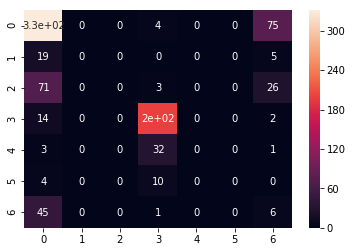

In [0]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y, pred)
np.set_printoptions(precision=2)

df_cm = pd.DataFrame(cnf_matrix, index = [str(x) for x in range(0, CLASS_NUM)],
                  columns = [str(x) for x in range(0, CLASS_NUM)])
sns.heatmap(df_cm, annot=True)

In [0]:
from sklearn.model_selection import StratifiedKFold

n_folds = 10
skf = StratifiedKFold(n_folds, shuffle=True)

for i, (train, test) in enumerate(skf.split(all_X,all_y)):
    print("Running Fold", i+1, "/", n_folds)
    estimator = KerasClassifier(build_fn=build_model, nb_epoch=24, batch_size=16, verbose=0)
    estimator.fit([all_X[train], all_X2[train]], all_y[train])

    pred = estimator.predict([all_X[test], all_X2[test]])
    print(accuracy_score(pred, all_y[test]))

Running Fold 1 / 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 7)                 399       
Total params: 399
Trainable params: 399
Non-trainable params: 0
_________________________________________________________________
None
0.5557729941291585
Running Fold 2 / 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 7)                 399       
Total params: 399
Trainable params: 399
Non-trainable params: 0
_________________________________________________________________
None
0.538160469667319
Running Fold 3 / 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 7)                 399       
Total params: 399
Trainable params: 399